- [R2RT - Blog](https://r2rt.com/implementing-batch-normalization-in-tensorflow.html)

In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

In [2]:
mnist = input_data.read_data_sets("data", one_hot=True)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
(784,)


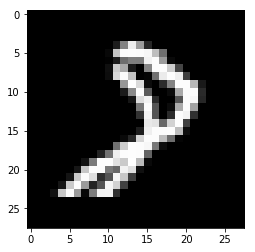

In [3]:
print(mnist.train.labels[3690])
print(mnist.train.images[3690].shape)
plt.imshow(mnist.train.images[3690].reshape((28, 28)), cmap="gray")

In [4]:
def compute_accuracy(y1, y2):
    return 100*((y1 == y2).astype(np.int).sum()/len(y1))

In [5]:
# initial values (fixed, in order to give comparable results)
np.random.seed(3690)

w1_init = np.random.randn(784, 100)
b1_init = np.random.randn(100)

w2_init = np.random.randn(100, 100)
b2_init = np.random.randn(100)

w3_init = np.random.randn(100, 10)
b3_init = np.random.randn(10)

In [6]:
# network without batch normalization
graph_no_bn = tf.Graph()

with graph_no_bn.as_default():
    tf_x_no_bn = tf.placeholder(dtype=tf.float32, 
                                shape=[None, 784])
    tf_y_no_bn = tf.placeholder(dtype=tf.float32, 
                                shape=[None, 10])
    
    # fully connected layer 1
    tf_W1_no_bn = tf.Variable(w1_init,
                              name="W1", 
                              dtype=tf.float32)
    tf_b1_no_bn = tf.Variable(b1_init,
                              name="b1",
                              dtype=tf.float32)
    tf_z1 = tf.matmul(tf_x_no_bn, tf_W1_no_bn) + tf_b1_no_bn
    tf_l1 = tf.nn.sigmoid(tf_z1)
    
    # fully connected layer 2
    tf_W2_no_bn = tf.Variable(w2_init, 
                              name="W2",
                              dtype=tf.float32)
    tf_b2_no_bn = tf.Variable(b2_init,
                              name="b2",
                              dtype=tf.float32)
    tf_z2 = tf.matmul(tf_l1, tf_W2_no_bn) + tf_b2_no_bn
    tf_l2 = tf.nn.sigmoid(tf_z2)
    
    # fully connect layer 3
    tf_W3_no_bn = tf.Variable(w3_init,
                              name="W3",
                              dtype=tf.float32)
    tf_b3_no_bn = tf.Variable(b3_init,
                              name="b3",
                              dtype=tf.float32)
    tf_l3 = tf.matmul(tf_l2, tf_W3_no_bn)+tf_b3_no_bn
    
    tf_y_hat_no_bn = tf.nn.softmax(tf_l3)
    predict_y_no_bn = tf.argmax(tf_l3, 1)
    
    cross_entropy_no_bn = -tf.reduce_sum(tf_y_no_bn*tf.log(tf_y_hat_no_bn))
    optimizer_no_bn = tf.train.GradientDescentOptimizer(learning_rate=0.01)
    train_no_nb = optimizer_no_bn.minimize(cross_entropy_no_bn)

In [7]:
batch_size=100
n_iterations = 40000

In [8]:
# SGD
loss_no_bn = [None for _ in range(n_iterations)]
accuracy_no_bn = [None for _ in range(n_iterations)]
with tf.Session(graph=graph_no_bn) as sess:
    tf.global_variables_initializer().run()
    for i in range(n_iterations):
        # training
        indices = np.random.choice(mnist.train.num_examples, batch_size)
        batch_images = mnist.train.images[indices]
        batch_labels = mnist.train.labels[indices]
        feed_dict = {tf_x_no_bn: batch_images, tf_y_no_bn:batch_labels}
        _ = sess.run(train_no_nb, feed_dict=feed_dict)
        l = sess.run(cross_entropy_no_bn, feed_dict=feed_dict)
        loss_no_bn[i] = l
        
        # prediction
        test_images, test_labels = mnist.test.next_batch(batch_size)
        feed_dict[tf_x_no_bn] = test_images
        feed_dict[tf_y_no_bn] = test_labels
        predict_y = sess.run(predict_y_no_bn, feed_dict=feed_dict)
        acc = compute_accuracy(predict_y, np.argmax(test_labels, axis=1))
        accuracy_no_bn[i] = acc
        
        if (i+1) % 1000 == 0:
            print("Iteration {}: {}, Test Accuracy: {}%".format(i+1, l, acc))
    train_variagles = [(v.name.split(":")[0], v.eval()) for v in tf.trainable_variables()]

Iteration 1000: 11.362983703613281, Test Accuracy: 88.0%
Iteration 2000: 14.395584106445312, Test Accuracy: 94.0%
Iteration 3000: 5.983454704284668, Test Accuracy: 91.0%
Iteration 4000: 10.788186073303223, Test Accuracy: 95.0%
Iteration 5000: 10.372574806213379, Test Accuracy: 95.0%
Iteration 6000: 7.307378768920898, Test Accuracy: 94.0%
Iteration 7000: 1.9053680896759033, Test Accuracy: 92.0%
Iteration 8000: 5.156550407409668, Test Accuracy: 98.0%
Iteration 9000: 2.987541675567627, Test Accuracy: 93.0%
Iteration 10000: 2.344890594482422, Test Accuracy: 96.0%
Iteration 11000: 1.3868452310562134, Test Accuracy: 95.0%
Iteration 12000: 1.8908889293670654, Test Accuracy: 96.0%
Iteration 13000: 2.4034361839294434, Test Accuracy: 91.0%
Iteration 14000: 1.7143120765686035, Test Accuracy: 97.0%
Iteration 15000: 3.8013792037963867, Test Accuracy: 95.0%
Iteration 16000: 1.6252985000610352, Test Accuracy: 96.0%
Iteration 17000: 2.6689209938049316, Test Accuracy: 94.0%
Iteration 18000: 1.102750182

In [9]:
print([v[0] for v in train_variagles])
print([v[1].shape for v in train_variagles])

['W1', 'b1', 'W2', 'b2', 'W3', 'b3']
[(784, 100), (100,), (100, 100), (100,), (100, 10), (10,)]


In [10]:
def normalize(tensor, mean, var):
    return (tensor - mean)/var

In [11]:
# Batch Normalized (BN) Neural Network
graph_bn = tf.Graph()

with graph_bn.as_default():
    tf_x_bn = tf.placeholder(dtype=tf.float32, shape=[None, 784])
    tf_y_bn = tf.placeholder(dtype=tf.float32, shape=[None, 10])
    
    # layer 1
    tf_W1_bn = tf.Variable(w1_init,
                           name="W1_bn",
                           dtype=tf.float32)
    tf_b1_bn = tf.Variable(b1_init,
                           name="b1_bn",
                           dtype=tf.float32)
    tf_z1_bn = tf.matmul(tf_x_bn, tf_W1_bn) + tf_b1_bn
    
    # BN for layer 1
    # Note that in order to make prediction with BN neural network,
    # we here construct two BN layers, one for training and one for prediction.
    # See https://arxiv.org/pdf/1502.03167v3.pdf section 3.1 for detail.
    tf_bn1_gamma = tf.Variable(tf.ones(w1_init.shape[-1]), 
                               dtype=tf.float32,
                               name="bn1_gamma")
    tf_bn1_beta = tf.Variable(tf.zeros(w1_init.shape[-1]), 
                              dtype=tf.float32,
                              name="bn1_beta")
    
    ## Prediction
    tf_z1_mean_predict = tf.placeholder(tf.float32, 
                                        shape=[w1_init.shape[-1]],
                                        name="z1_mean_predict")
    tf_z1_var_predict = tf.placeholder(tf.float32, 
                                       shape=[w1_init.shape[-1]],
                                       name="z1_var_predict")
    tf_l1_predict = tf.sigmoid(tf_bn1_gamma*normalize(tf_z1_bn, tf_z1_mean_predict, tf_z1_var_predict)+tf_bn1_beta)
    
    ## Training
    tf_z1_mean, tf_z1_var = tf.nn.moments(tf_z1_bn, [0])
    tf_l1 = tf_bn1_gamma*normalize(tf_z1_bn, tf_z1_mean, tf_z1_var) + tf_bn1_beta
    
    # layer 2
    tf_W2_bn = tf.Variable(w2_init,
                           name="W2_bn",
                           dtype=tf.float32)
    tf_b2_bn = tf.Variable(b2_init,
                           name="b2_bn",
                           dtype=tf.float32)
    # for training
    tf_z2_bn = tf.matmul(tf_l1, tf_W2_bn) + tf_b2_bn
    # for prediction
    tf_z2_bn_predict = tf.matmul(tf_l1_predict, tf_W2_bn) + tf_b2_bn
    
    # BN layer 2
    tf_bn2_gamma = tf.Variable(tf.ones(w2_init.shape[-1]),
                               dtype=tf.float32,
                               name="bn2_gamma")
    tf_bn2_beta = tf.Variable(tf.ones(w2_init.shape[-1]),
                              dtype=tf.float32,
                              name="bn2_beta")
    ## Predict
    tf_z2_mean_predict = tf.placeholder(tf.float32, 
                                        shape=w2_init.shape[-1],
                                        name="z2_mean_predict")
    tf_z2_var_predict = tf.placeholder(tf.float32, 
                                       shape=w2_init.shape[-1],
                                       name="z2_var_predict")
    tf_l2_predict = tf.sigmoid(tf_bn2_gamma*normalize(tf_z2_bn_predict, tf_z2_mean_predict, tf_z2_var_predict)+tf_bn2_beta)
    
    ## Training
    tf_z2_mean, tf_z2_var = tf.nn.moments(tf_z2_bn, [0])
    tf_l2 = tf.sigmoid(tf_bn2_gamma*normalize(tf_z2_bn, tf_z2_mean, tf_z2_var)+tf_bn2_beta)
    
    # layer 3
    tf_W3_bn = tf.Variable(w3_init,
                           name="W3_bn",
                          dtype=tf.float32)
    tf_b3_bn = tf.Variable(b3_init,
                           name="b3_bn",
                           dtype=tf.float32)
    ## Predict
    tf_z3_predict = tf.matmul(tf_l2_predict, tf_W3_bn)+tf_b3_bn
    tf_l3_predict = tf.nn.softmax(tf_z3_predict)
    predict_y_bn = tf.arg_max(tf_l3_predict, 1)
    
    ## Training
    tf_z3 = tf.matmul(tf_l2, tf_W3_bn)+tf_b3_bn
    tf_l3 = tf.nn.softmax(tf_z3)
    cross_entropy_bn = -tf.reduce_sum(tf_y_bn*tf.log(tf_l3))
    train_op_bn = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cross_entropy_bn) 

In [12]:
def update_means_vars(means, variances, new_means, new_variances, decay_rate=0.99):
    for i in range(len(means)):
        if means[i] is None:
            means[i] = new_means[i]
        else:
            means[i] = decay_rate*means[i] + (1-decay_rate)*new_means[i]
        
        if variances[i] is None:
            variances[i] = new_variances[i]
        else:
            variances[i] = decay_rate*variances[i] + (1-decay_rate)*new_variances[i]

In [13]:
# training
loss_bn = [None for _ in range(n_iterations)]
accuracy_bn = [None for _ in range(n_iterations)]
decay_rate = 0.9
train_means = [None, None]
train_vars = [None, None]
to_eval_means = [tf_z1_mean, tf_z2_mean]
to_eval_vars = [tf_z1_var, tf_z2_var]
with tf.Session(graph=graph_bn) as sess:
    tf.global_variables_initializer().run()
    for i in range(n_iterations):
        # training
        indices = np.random.choice(mnist.train.num_examples, batch_size)
        batch_images = mnist.train.images[indices]
        batch_labels = mnist.train.labels[indices]
        feed_dict = {tf_x_bn:batch_images, tf_y_bn:batch_labels}
        _ = sess.run(train_op_bn, feed_dict=feed_dict)
        means = sess.run(to_eval_means, feed_dict=feed_dict)
        variances = sess.run(to_eval_vars, feed_dict=feed_dict)
        update_means_vars(train_means, train_vars, means, variances, decay_rate)
        l = sess.run(cross_entropy_bn, feed_dict=feed_dict)
        loss_bn[i] = l
        
        # prediction
        indices = np.random.choice(mnist.test.num_examples, batch_size)
        test_images = mnist.test.images[indices]
        test_labels = mnist.test.labels[indices]
        feed_dict[tf_x_bn] = test_images
        feed_dict[tf_y_bn] = test_labels
        feed_dict[tf_z1_mean_predict] = train_means[0]
        feed_dict[tf_z2_mean_predict] = train_means[1]
        feed_dict[tf_z1_var_predict] = train_vars[0]
        feed_dict[tf_z2_var_predict] = train_vars[1]
        predict_y = sess.run(predict_y_bn, feed_dict=feed_dict)
        acc = compute_accuracy(predict_y, np.argmax(test_labels, axis=1))
        accuracy_bn[i] = acc
        
        if (i+1) % 1000 == 0:
            print("Iteration {}:{}, Test Accuracy:{}%".format(i+1, l, acc))

Iteration 1000:30.528104782104492, Test Accuracy:5.0%
Iteration 2000:20.332050323486328, Test Accuracy:5.0%
Iteration 3000:13.255681991577148, Test Accuracy:18.0%
Iteration 4000:13.71622371673584, Test Accuracy:11.0%
Iteration 5000:11.189128875732422, Test Accuracy:12.0%
Iteration 6000:9.45019817352295, Test Accuracy:10.0%
Iteration 7000:4.857962608337402, Test Accuracy:9.0%
Iteration 8000:11.938272476196289, Test Accuracy:7.000000000000001%
Iteration 9000:6.530673503875732, Test Accuracy:12.0%
Iteration 10000:11.289300918579102, Test Accuracy:5.0%
Iteration 11000:5.397082328796387, Test Accuracy:6.0%
Iteration 12000:6.986323833465576, Test Accuracy:13.0%
Iteration 13000:4.0463385581970215, Test Accuracy:9.0%
Iteration 14000:4.8478240966796875, Test Accuracy:10.0%
Iteration 15000:3.588296413421631, Test Accuracy:7.000000000000001%
Iteration 16000:4.114387512207031, Test Accuracy:10.0%
Iteration 17000:4.2693095207214355, Test Accuracy:10.0%
Iteration 18000:8.775794982910156, Test Accura

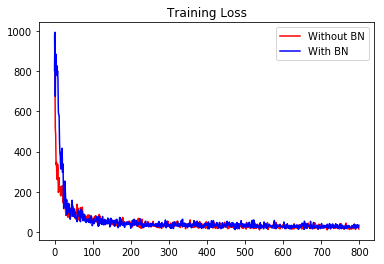

In [14]:
plt.title("Training Loss")
line_no_bn, = plt.plot(loss_no_bn[:800], "r-")
line_bn, = plt.plot(loss_bn[:800], "b-")
plt.legend([line_no_bn, line_bn], ["Without BN", "With BN"])

In [15]:
for train_mean in train_means:
    print(train_mean.shape)

(100,)
(100,)
